📦 Setup & Libraries

In [ ]:
# === Portfolio Optimization with Sector-Based Equal Investment ===
# This notebook performs portfolio optimization based on Modern Portfolio Theory (Markowitz),
# ensuring equal sector representation. It integrates:
# - Expected return & volatility analysis
# - Risk-adjusted performance metrics (Sharpe, Sortino, Calmar)
# - Risk decomposition (Expected Shortfall, Herfindahl index, Entropy)
# - Out-of-sample validation with train/test split
# - Capital Market Line visualization with a synthetic risk-free asset

# --- Import essential Python libraries ---
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# For consistent results in randomized operations
np.random.seed(42)

# Matplotlib default style
plt.style.use("ggplot")

📄 Load Company & Sector Information

In [ ]:
# === STEP 1: Load and clean company-sector mapping ===
# This step loads the list of selected companies and maps each ticker to its respective sector.

# Load CSV containing ticker-symbols and sectors
df_companies = pd.read_csv("selected_company_sample.csv")

# Ensure consistent column naming
df_companies.rename(columns={'Symbol': 'Ticker'}, inplace=True)

# Extract unique sectors from the dataset
sectors = df_companies['Sector'].unique()

# Display the number of sectors and a preview of the mapping
print(f"Total sectors: {len(sectors)}")
print("Sample of sector-ticker mapping:")
print(df_companies.head())

Total sectors: 3
Sample of sector-ticker mapping:
   Unnamed: 0 Ticker                    Name                  Sector
0         106    CMG  Chipotle Mexican Grill  Consumer Discretionary
1         313    MHK       Mohawk Industries  Consumer Discretionary
2         206   GRMN             Garmin Ltd.  Consumer Discretionary
3         279    LEG         Leggett & Platt  Consumer Discretionary
4         345   ORLY     O'Reilly Automotive  Consumer Discretionary


🧼 Clean Individual Stock Data

In [ ]:
# === STEP 2: Define helper function to clean stock data ===
# This function standardizes stock price CSVs:
# - Renames columns
# - Parses dates
# - Converts 'close' prices to float
# - Sets the date as index
# It assumes files are structured with columns like: Date, Close/Last, Volume, etc.

def clean_stock_data(filepath):
    # Read CSV
    df = pd.read_csv(filepath)

    # Standardize column names (lowercase, underscores)
    df.columns = [col.strip().lower().replace('/', '_').replace(' ', '_') for col in df.columns]

    # Rename 'close_last' to 'close' if needed
    if 'close_last' in df.columns:
        df.rename(columns={'close_last': 'close'}, inplace=True)

    # Convert price strings to float
    df['close'] = df['close'].replace('[\$,]', '', regex=True).astype(float)

    # Parse and set date index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Return only closing price
    return df[['close']]


🗂️ Load All Sector Data from CSV Files

In [ ]:
# === STEP 3: Load data by sector ===
# For each sector, this function loads all stock price series into a DataFrame.
# Each sector is stored in a dictionary: { sector_name: DataFrame of tickers }

def load_sector_data(tickers, folder='stocks'):
    data = pd.DataFrame()
    for ticker in tickers:
        filepath = os.path.join(folder, f"{ticker}.csv")
        try:
            stock_data = clean_stock_data(filepath)
            data[ticker] = stock_data['close']
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
    return data

# Load data for all sectors and store in a dictionary
sector_data = {}
for sector in sectors:
    tickers = df_companies[df_companies['Sector'] == sector]['Ticker'].tolist()
    sector_data[sector] = load_sector_data(tickers)

# Show example of one sector's data
example_sector = list(sector_data.keys())[0]
print(f"\nSample data for sector: {example_sector}")
print(sector_data[example_sector].head())



Sample data for sector: Consumer Discretionary
              CMG     MHK    GRMN   LEG     ORLY
date                                            
2025-06-13  50.24  101.43  201.32  9.24  89.9100
2025-06-12  50.89  104.77  208.39  9.62  91.0500
2025-06-11  51.79  104.71  209.13  9.58  90.0100
2025-06-10  50.62  105.94  210.12  9.62  91.7100
2025-06-09  51.13  103.10  208.29  9.25  89.8734


📈 Compute Daily Returns per Sector

In [ ]:
# === STEP 4: Compute daily returns ===
# We compute the daily percentage returns for each stock in each sector.

# This will create a dictionary { sector_name: DataFrame of daily returns }
sector_returns = {
    sector: data.pct_change().dropna()
    for sector, data in sector_data.items()
}

# Print a preview of returns for one sector
example_sector = list(sector_returns.keys())[0]
print(f"\nSample daily returns for sector: {example_sector}")
print(sector_returns[example_sector].head())


Sample daily returns for sector: Consumer Discretionary
                 CMG       MHK      GRMN       LEG      ORLY
date                                                        
2025-06-12  0.012938  0.032929  0.035118  0.041126  0.012679
2025-06-11  0.017685 -0.000573  0.003551 -0.004158 -0.011422
2025-06-10 -0.022591  0.011747  0.004734  0.004175  0.018887
2025-06-09  0.010075 -0.026808 -0.008709 -0.038462 -0.020026
2025-06-06  0.026794 -0.015325 -0.004033 -0.016216  0.021971


C:\Users\longo\AppData\Local\Temp\ipykernel_20060\744429767.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sector: data.pct_change().dropna()


🧮 Intra-Sector Optimization & Combine Portfolios

In [8]:
# === STEP 5: Optimize portfolio within each sector ===
# We apply minimum variance optimization using Ledoit-Wolf shrinkage estimator.

def get_optimal_weights(returns):
    n = returns.shape[1]

    # Ledoit-Wolf shrinkage covariance estimator (more robust with small samples)
    lw = LedoitWolf().fit(returns)
    cov = lw.covariance_ * 252  # annualized covariance

    # Objective function: portfolio volatility
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    # Constraints and bounds
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array(n * [1. / n])

    result = minimize(portfolio_volatility, initial_guess, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x

# === STEP 6: Combine sector portfolios equally ===
# Each sector contributes equally to the final portfolio.

all_tickers = []
all_weights = []

for sector in sectors:
    returns = sector_returns[sector]
    tickers = returns.columns
    weights = get_optimal_weights(returns)
    scaled_weights = weights * (1 / len(sectors))  # equal sector allocation

    all_tickers.extend(tickers)
    all_weights.extend(scaled_weights)

# Construct final portfolio
final_portfolio = pd.DataFrame({
    'Ticker': all_tickers,
    'Weight': all_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Display result
print("Final Portfolio Allocation (Equal Sector Allocation):")
print(final_portfolio)


Final Portfolio Allocation (Equal Sector Allocation):
   Ticker        Weight
0      CB  1.340393e-01
1    ORLY  1.262290e-01
2     IBM  1.242830e-01
3    GRMN  1.131929e-01
4      EA  8.692634e-02
5     AXP  7.147067e-02
6    EBAY  6.296407e-02
7      MS  6.084505e-02
8     BAC  6.070550e-02
9     CMG  6.037037e-02
10     IT  5.915997e-02
11    LEG  2.742648e-02
12     XL  6.272809e-03
13    MHK  6.114575e-03
14   AVGO  2.258755e-19


🥧 Plot Portfolio Allocation Pie Chart

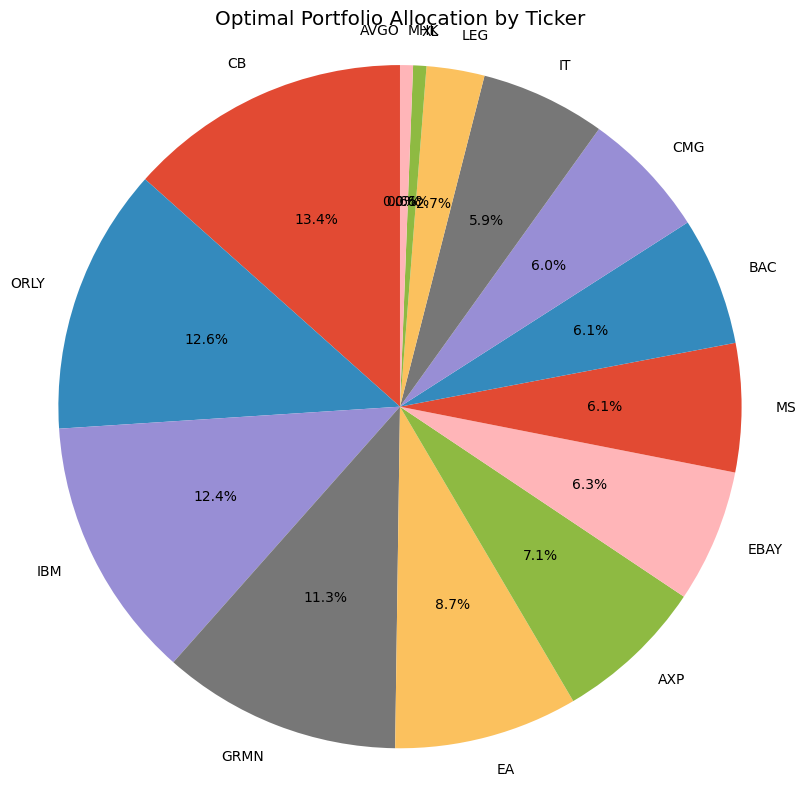

In [9]:
# === Optional: Plot pie chart ===
# Visualize the final portfolio allocation using a pie chart.

plt.figure(figsize=(8, 8))
plt.pie(
    final_portfolio['Weight'],
    labels=final_portfolio['Ticker'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Optimal Portfolio Allocation by Ticker')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.tight_layout()
plt.show()

🧪 Add Risk-Free Asset and Split Data

In [10]:
# === STEP 8: Combine all sector returns and add synthetic risk-free asset ===
# We create a unified returns DataFrame and append a constant risk-free asset.
# The data is then split into training, validation, and test sets.

# Merge all returns into one DataFrame
returns_df = pd.concat(sector_returns.values(), axis=1).dropna()

# --- Add synthetic risk-free asset (constant daily return) ---
risk_free_rate_daily = 0.0001  # ≈ 2.5% annualized
risk_free = pd.Series(risk_free_rate_daily, index=returns_df.index, name='RISK_FREE')
returns_df = pd.concat([returns_df, risk_free], axis=1)

# Sort chronologically (safety step)
returns_df = returns_df.sort_index()

# Determine date boundaries for train/val/test split
end_date = returns_df.index.max()
test_start = end_date - pd.DateOffset(months=6)
val_start = end_date - pd.DateOffset(months=12)

# Perform split
returns_train = returns_df[returns_df.index < val_start]
returns_val = returns_df[(returns_df.index >= val_start) & (returns_df.index < test_start)]
returns_test = returns_df[returns_df.index >= test_start]
returns_modeling = pd.concat([returns_train, returns_val]).sort_index()

# --- Sanity checks ---
if len(returns_train) == 0 or len(returns_test) == 0:
    raise ValueError("Dataset too short: ensure at least 12 months of data.")

# Summary output
print("Train set:     ", returns_train.index.min().date(), "→", returns_train.index.max().date(), f"({len(returns_train)} rows)")
print("Validation set:", returns_val.index.min().date(), "→", returns_val.index.max().date(), f"({len(returns_val)} rows)")
print("Test set:      ", returns_test.index.min().date(), "→", returns_test.index.max().date(), f"({len(returns_test)} rows)")

Train set:      2015-06-16 → 2024-06-11 (2263 rows)
Validation set: 2024-06-12 → 2024-12-11 (127 rows)
Test set:       2024-12-12 → 2025-06-12 (124 rows)


📊 Efficient Frontier & Max Sharpe Portfolio (Tangency Portfolio)

In [11]:
# === STEP 9: Compute Efficient Frontier and Tangency Portfolio ===
# This section computes:
# - the maximum Sharpe ratio portfolio (tangency)
# - the efficient frontier of mean-variance portfolios

# Extract symbols and compute statistics
symbols = returns_df.columns
mean_returns = returns_modeling.mean()
lw = LedoitWolf().fit(returns_modeling)
cov_matrix = lw.covariance_
n_assets = len(symbols)

# Set annualized risk-free rate
rf = risk_free_rate_daily * 252  # ≈ 2.5%

# --- Max Sharpe Ratio Portfolio (Tangency Portfolio) ---
def negative_sharpe(weights, mu, cov, rf=0.0):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(weights.T @ cov @ weights)
    return - (port_return - rf) / port_vol

bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
initial_guess = np.repeat(1 / n_assets, n_assets)

result = minimize(negative_sharpe, initial_guess,
                  args=(mean_returns, cov_matrix, rf),
                  method='SLSQP', bounds=bounds, constraints=constraints)

tangent_weights = result.x
tangent_return = np.dot(tangent_weights, mean_returns) * 252
tangent_vol = np.sqrt(tangent_weights.T @ cov_matrix @ tangent_weights) * np.sqrt(252)
tangent_sharpe = (tangent_return - rf) / tangent_vol

# --- Efficient Frontier ---
efficient_returns = []
efficient_risks = []
efficient_weights = []

target_returns = np.linspace(0.0001, 0.003, 100)  # Daily returns

for target_return in target_returns:
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}
    ]

    result = minimize(portfolio_volatility, initial_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        efficient_returns.append(target_return)
        efficient_risks.append(result.fun)
        efficient_weights.append(result.x)

# Convert to annualized metrics
annual_returns = [r * 252 for r in efficient_returns]
annual_vols = [v * np.sqrt(252) for v in efficient_risks]

# Sharpe ratios for frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(efficient_returns, efficient_risks)]
max_sharpe_idx = np.argmax(sharpe_ratios)
min_var_idx = np.argmin(efficient_risks)

# Store optimal weights
max_sharpe_weights = efficient_weights[max_sharpe_idx]
min_var_weights = efficient_weights[min_var_idx]

# Output info
print(f"Max Sharpe Portfolio Return:    {annual_returns[max_sharpe_idx]:.4f}")
print(f"Max Sharpe Portfolio Volatility:{annual_vols[max_sharpe_idx]:.4f}")
print(f"Max Sharpe Ratio:               {sharpe_ratios[max_sharpe_idx]:.4f}")

Max Sharpe Portfolio Return:    0.7560
Max Sharpe Portfolio Volatility:0.7602
Max Sharpe Ratio:               -0.4636


📉 Plot Efficient Frontier and Capital Market Line (CML)

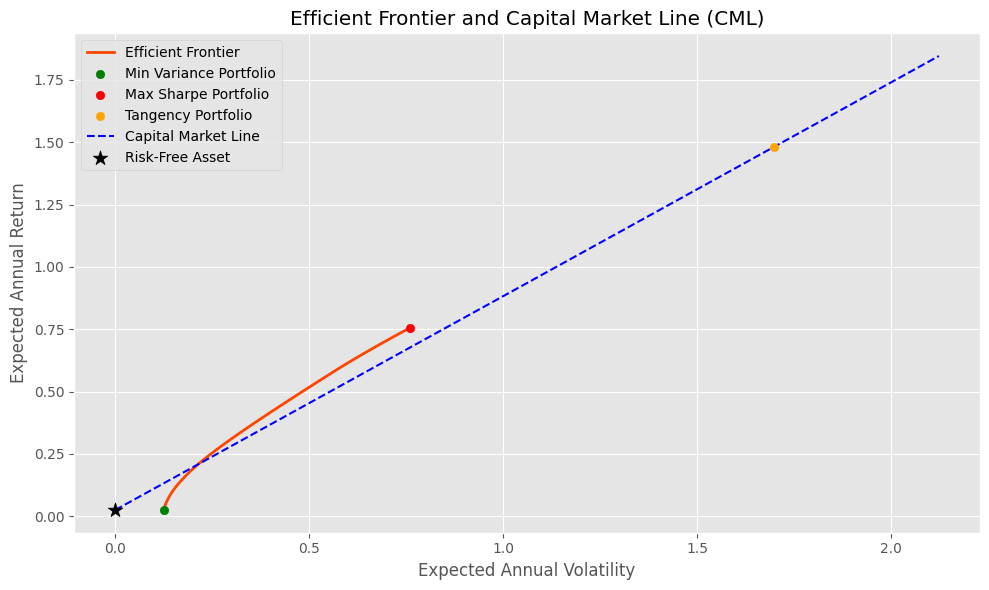

In [20]:
# === STEP 10: Plot Efficient Frontier and Capital Market Line (CML) ===
# This plot shows:
# - the efficient frontier
# - the Capital Market Line (CML)
# - the minimum variance and max Sharpe portfolios
# - the synthetic risk-free asset

plt.figure(figsize=(10, 6))

# Efficient Frontier
plt.plot(annual_vols, annual_returns, label='Efficient Frontier', linewidth=2, color='orangered')

# Key Portfolios
plt.scatter(annual_vols[min_var_idx], annual_returns[min_var_idx],
            color='green', label='Min Variance Portfolio', zorder=5)
plt.scatter(annual_vols[max_sharpe_idx], annual_returns[max_sharpe_idx],
            color='red', label='Max Sharpe Portfolio', zorder=5)
plt.scatter(tangent_vol, tangent_return,
            color='orange', label='Tangency Portfolio', zorder=5)

# === Recompute tangent_sharpe properly ===
tangent_sharpe = (tangent_return - rf) / tangent_vol

# Capital Market Line: line from (0, rf) to (tangent_vol, tangent_return)
cml_volatility = np.linspace(0, tangent_vol * 1.25, 100)
cml_return = rf + tangent_sharpe * cml_volatility
plt.plot(cml_volatility, cml_return, linestyle='--', color='blue', label='Capital Market Line')

# Risk-Free Asset
plt.scatter(0, rf, color='black', marker='*', s=120, label='Risk-Free Asset', zorder=5)

# Labels and legend
plt.xlabel('Expected Annual Volatility')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier and Capital Market Line (CML)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

💾 Portfolio Weights and Export to CSV

In [13]:
# === STEP 11: Show and Export Optimal Portfolio Weights ===
# Display the asset allocations for the Min Variance and Max Sharpe portfolios
# and save them to CSV files.

# Display Minimum Variance Portfolio Weights
print("\n--- Minimum Variance Portfolio Weights ---")
for sym, w in zip(symbols, min_var_weights):
    if w > 0.001:
        print(f"{sym}: {w:.4f}")

# Display Maximum Sharpe Ratio Portfolio Weights
print("\n--- Maximum Sharpe Ratio Portfolio Weights ---")
for sym, w in zip(symbols, max_sharpe_weights):
    if w > 0.001:
        print(f"{sym}: {w:.4f}")

# Create and export DataFrames
min_var_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': min_var_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

max_sharpe_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': max_sharpe_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Save to CSV
final_portfolio.to_csv("final_portfolio.csv", index=False)
min_var_portfolio.to_csv("min_variance_portfolio.csv", index=False)
max_sharpe_portfolio.to_csv("max_sharpe_portfolio.csv", index=False)

print("\nPortfolio weights saved to CSV files:")
print("- final_portfolio.csv (Equal Sector Allocation)")
print("- min_variance_portfolio.csv (Minimum Variance Portfolio)")
print("- max_sharpe_portfolio.csv (Maximum Sharpe Ratio Portfolio)")



--- Minimum Variance Portfolio Weights ---
CMG: 0.0340
MHK: 0.0074
GRMN: 0.0249
LEG: 0.0533
ORLY: 0.0331
XL: 0.0155
CB: 0.0630
IBM: 0.0898
EBAY: 0.0457
EA: 0.0750
RISK_FREE: 0.5583

--- Maximum Sharpe Ratio Portfolio Weights ---
LEG: 0.5732
XL: 0.4268

Portfolio weights saved to CSV files:
- final_portfolio.csv (Equal Sector Allocation)
- min_variance_portfolio.csv (Minimum Variance Portfolio)
- max_sharpe_portfolio.csv (Maximum Sharpe Ratio Portfolio)


⚠️ Define Risk and Performance Metrics

In [15]:
# === Additional Utilities: Risk and Performance Metrics ===

def expected_shortfall(returns, alpha=0.05):
    """
    Expected Shortfall (CVaR): average loss in the worst alpha% of cases.
    """
    sorted_returns = np.sort(returns)
    cutoff_index = int(np.ceil(alpha * len(sorted_returns)))
    return -np.mean(sorted_returns[:cutoff_index])

def sortino_ratio(returns, target=0):
    """
    Sortino Ratio: uses downside deviation instead of total volatility.
    """
    downside = returns[returns < target]
    downside_std = np.std(downside) if len(downside) > 0 else 1e-6
    return (returns.mean() - target) / downside_std

def calmar_ratio(returns):
    """
    Calmar Ratio: annual return divided by the absolute value of the maximum drawdown.
    """
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    annual_return = returns.mean() * 252
    return annual_return / abs(max_drawdown) if max_drawdown < 0 else np.nan

📅 Out-of-Sample Performance Evaluation


=== Out-of-Sample Performance (Last 6 Months) ===

Max Sharpe Portfolio:
  Return:     0.9611
  Volatility: 0.6064
  Sharpe:     1.5434
  Sortino:    0.1470
  Calmar:     4.3989
  CVaR 5%:    0.0808

Min Variance Portfolio:
  Return:     0.0696
  Volatility: 0.0947
  Sharpe:     0.4686
  Sortino:    0.0676
  Calmar:     1.1382
  CVaR 5%:    0.0128


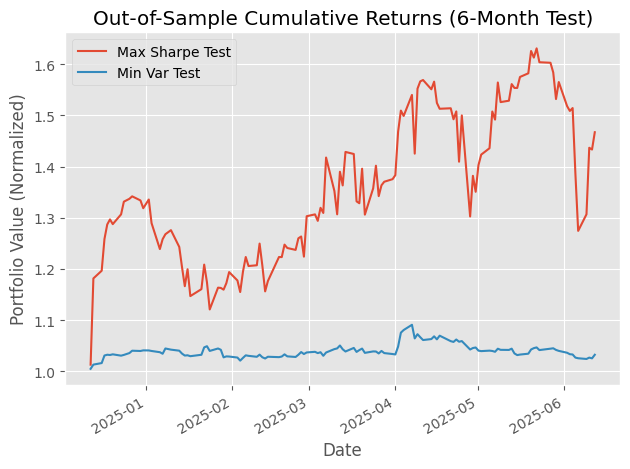

In [16]:
# === STEP 12: Evaluate Out-of-Sample Performance (Test Set) ===
# We apply the optimal portfolios to unseen test data (last 6 months)
# and compute risk-adjusted performance metrics.

# Helper: compute portfolio returns
def compute_portfolio_returns(weights, returns_df):
    return returns_df @ weights

# Portfolio returns on test set
max_sharpe_test = compute_portfolio_returns(max_sharpe_weights, returns_test)
min_var_test = compute_portfolio_returns(min_var_weights, returns_test)

# Helper: risk metrics
def evaluate_returns(r):
    annual_return = r.mean() * 252
    volatility = r.std() * np.sqrt(252)
    sharpe = (annual_return - rf) / volatility
    sortino = sortino_ratio(r)
    calmar = calmar_ratio(r)
    es = expected_shortfall(r.values, alpha=0.05)
    return annual_return, volatility, sharpe, sortino, calmar, es

# Evaluate both portfolios
metrics_sharpe = evaluate_returns(max_sharpe_test)
metrics_minvar = evaluate_returns(min_var_test)

# Print results
print("\n=== Out-of-Sample Performance (Last 6 Months) ===")
print(f"\nMax Sharpe Portfolio:")
print(f"  Return:     {metrics_sharpe[0]:.4f}")
print(f"  Volatility: {metrics_sharpe[1]:.4f}")
print(f"  Sharpe:     {metrics_sharpe[2]:.4f}")
print(f"  Sortino:    {metrics_sharpe[3]:.4f}")
print(f"  Calmar:     {metrics_sharpe[4]:.4f}")
print(f"  CVaR 5%:    {metrics_sharpe[5]:.4f}")

print(f"\nMin Variance Portfolio:")
print(f"  Return:     {metrics_minvar[0]:.4f}")
print(f"  Volatility: {metrics_minvar[1]:.4f}")
print(f"  Sharpe:     {metrics_minvar[2]:.4f}")
print(f"  Sortino:    {metrics_minvar[3]:.4f}")
print(f"  Calmar:     {metrics_minvar[4]:.4f}")
print(f"  CVaR 5%:    {metrics_minvar[5]:.4f}")

# Plot cumulative returns
(1 + max_sharpe_test).cumprod().plot(label='Max Sharpe Test')
(1 + min_var_test).cumprod().plot(label='Min Var Test')
plt.title('Out-of-Sample Cumulative Returns (6-Month Test)')
plt.ylabel('Portfolio Value (Normalized)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🧠 Diversification & Risk Contribution Analysis


Diversification Metrics:
 - Min Variance: Entropy = 1.6284, Herfindahl = 0.3374
 - Max Sharpe:   Entropy = 0.6824, Herfindahl = 0.5107

--- Risk Contributions (as % of total volatility) ---
Min Variance Portfolio:
RISK_FREE: 55.67%

Max Sharpe Portfolio:
LEG: 8.75%
XL: 91.25%


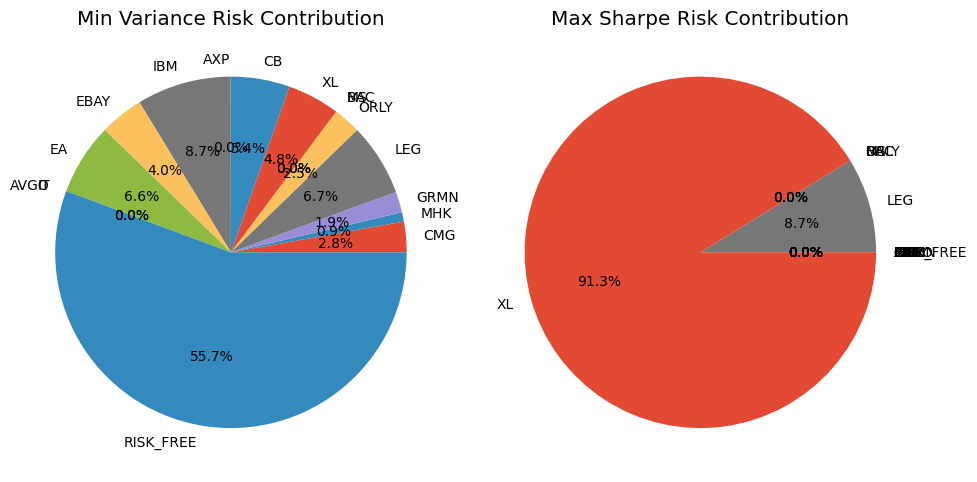

In [17]:
# === STEP 13: Diversification and Risk Contributions ===

# Entropy and Herfindahl Index
def entropy(weights):
    """Shannon entropy: higher → more diversified"""
    weights = np.array(weights)
    return -np.sum(weights * np.log(weights + 1e-10))  # avoid log(0)

def herfindahl(weights):
    """Herfindahl-Hirschman Index: lower → more diversified"""
    weights = np.array(weights)
    return np.sum(weights**2)

# Risk Contributions
def risk_contributions(weights, cov_matrix):
    """
    Computes the risk contribution of each asset to portfolio volatility.
    Returns: (individual contributions, total volatility)
    """
    weights = np.array(weights)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    mrc = (cov_matrix @ weights) / port_vol  # Marginal Risk Contribution
    rc = weights * mrc  # Total risk contribution per asset
    return rc, port_vol

# Compute metrics
ent_min_var = entropy(min_var_weights)
ent_max_sharpe = entropy(max_sharpe_weights)
herf_min_var = herfindahl(min_var_weights)
herf_max_sharpe = herfindahl(max_sharpe_weights)

print(f"\nDiversification Metrics:")
print(f" - Min Variance: Entropy = {ent_min_var:.4f}, Herfindahl = {herf_min_var:.4f}")
print(f" - Max Sharpe:   Entropy = {ent_max_sharpe:.4f}, Herfindahl = {herf_max_sharpe:.4f}")

# Compute risk contributions
rc_min_var, vol_min_var = risk_contributions(min_var_weights, cov_matrix)
rc_max_sharpe, vol_max_sharpe = risk_contributions(max_sharpe_weights, cov_matrix)

# Print contributions as %
print("\n--- Risk Contributions (as % of total volatility) ---")
print("Min Variance Portfolio:")
for sym, rc in zip(symbols, rc_min_var):
    if rc > 0.001:
        print(f"{sym}: {(rc / vol_min_var) * 100:.2f}%")

print("\nMax Sharpe Portfolio:")
for sym, rc in zip(symbols, rc_max_sharpe):
    if rc > 0.001:
        print(f"{sym}: {(rc / vol_max_sharpe) * 100:.2f}%")

# Plot pie charts
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(rc_min_var, labels=symbols, autopct='%1.1f%%')
plt.title('Min Variance Risk Contribution')

plt.subplot(1, 2, 2)
plt.pie(rc_max_sharpe, labels=symbols, autopct='%1.1f%%')
plt.title('Max Sharpe Risk Contribution')

plt.tight_layout()
plt.show()



🟠 Save and Visualize Tangency Portfolio


--- Tangency Portfolio (True Max Sharpe) ---
Expected Return: 1.4812
Volatility:      1.6984
Sharpe Ratio:    0.8573
Weights (RISK_FREE included):
  XL: 1.0000


<Figure size 1000x600 with 0 Axes>

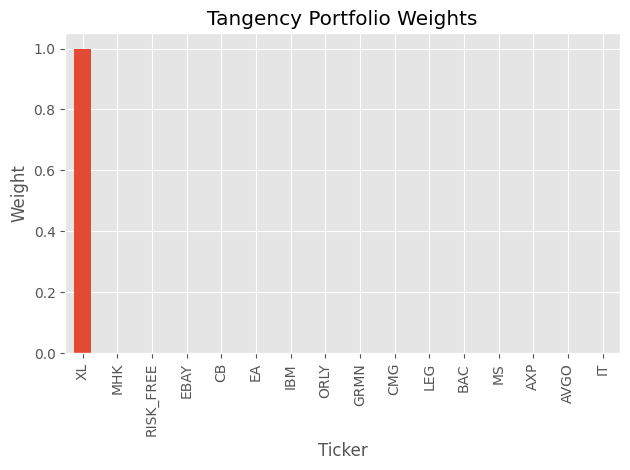

In [18]:
# === STEP 14: Save and Visualize Tangency Portfolio ===
# We export the tangency portfolio weights and visualize them with a bar chart.

# Create DataFrame for tangency portfolio
tangency_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': tangent_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Save to CSV
tangency_portfolio.to_csv("tangency_portfolio.csv", index=False)

# Display weights
print("\n--- Tangency Portfolio (True Max Sharpe) ---")
print(f"Expected Return: {tangent_return:.4f}")
print(f"Volatility:      {tangent_vol:.4f}")
print(f"Sharpe Ratio:    {tangent_sharpe:.4f}")
print("Weights (RISK_FREE included):")
for sym, w in zip(symbols, tangent_weights):
    if w > 0.001:
        print(f"  {sym}: {w:.4f}")

# Bar chart of weights
plt.figure(figsize=(10, 6))
tangency_portfolio.plot(kind='bar', x='Ticker', y='Weight', legend=False)
plt.title('Tangency Portfolio Weights')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

🧾 Final Notes & Next Steps (Markdown)

## ✅ Notebook Complete: Sector-Based Portfolio Optimization with Markowitz Theory

### Summary

In this notebook, we:
- Loaded sector-specific stock data and ensured equal sector representation
- Computed daily returns and optimized intra-sector portfolios using minimum variance
- Combined sector portfolios into a global one
- Added a synthetic risk-free asset and split data into training, validation, and test
- Built and visualized the efficient frontier and the Capital Market Line (CML)
- Identified and analyzed the Min Variance, Max Sharpe, and Tangency Portfolios
- Evaluated out-of-sample performance over the last 6 months
- Analyzed diversification (Entropy, Herfindahl) and risk contributions
- Saved all portfolios to CSV and visualized weights

### Files Generated
- `final_portfolio.csv`
- `min_variance_portfolio.csv`
- `max_sharpe_portfolio.csv`
- `tangency_portfolio.csv`

---
